# Проект - Промышленность

# Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Цель проекта:** Построить модель которая предскажет температуру стали

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии.  
В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# План работы

- Загрузить и проанализировать данные
- Определить признаки для обучения моделей и целевой признак
- Построить и обучить модели, оценить их качество
- Оценка лучшей модели на тестовой выборке
- Вывод

# Загрузка бибилотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split 
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


RND = 240423

# Загрузка данных

In [2]:
try:
    data_arc = pd.read_csv('C:/Users/123/Downloads/data_arc_new.csv')
    data_bulk = pd.read_csv('C:/Users/123/Downloads/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('C:/Users/123/Downloads/data_bulk_time_new.csv')
    data_gas = pd.read_csv('C:/Users/123/Downloads/data_gas_new.csv')
    data_temp = pd.read_csv('C:/Users/123/Downloads/data_temp_new.csv')
    data_wire = pd.read_csv('C:/Users/123/Downloads/data_wire_new.csv')
    data_wire_time = pd.read_csv('C:/Users/123/Downloads/data_wire_time_new.csv')
    
except:
    data_arc = pd.read_csv('data_arc_new.csv')
    data_bulk = pd.read_csv('data_bulk_new.csv')
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_wire = pd.read_csv('data_wire_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv')

# Анализ данных

In [3]:
def check_data(data):
    display(data.head(2))
    display(data.tail(2))
    print('')
    print('_________________ Информация _________________')
    print('')
    print(data.info())
    print('')
    print('_________________ Статистика _________________')
    print('')
    display(data.describe())
    print('')
    print('__________________ Пропуски(%) __________________')
    print('')
    print(data.isna().sum()/len(data)*100)
    

## Данные об электродах

In [4]:
check_data(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347



_________________ Информация _________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

_________________ Статистика _________________



,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



__________________ Пропуски(%) __________________

key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64


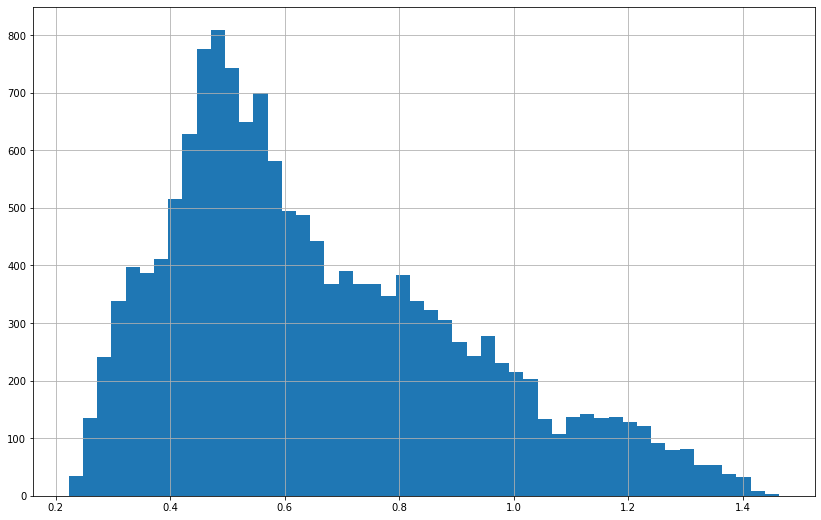

In [5]:
data_arc['Активная мощность'].hist(bins=50, figsize=(14,9));

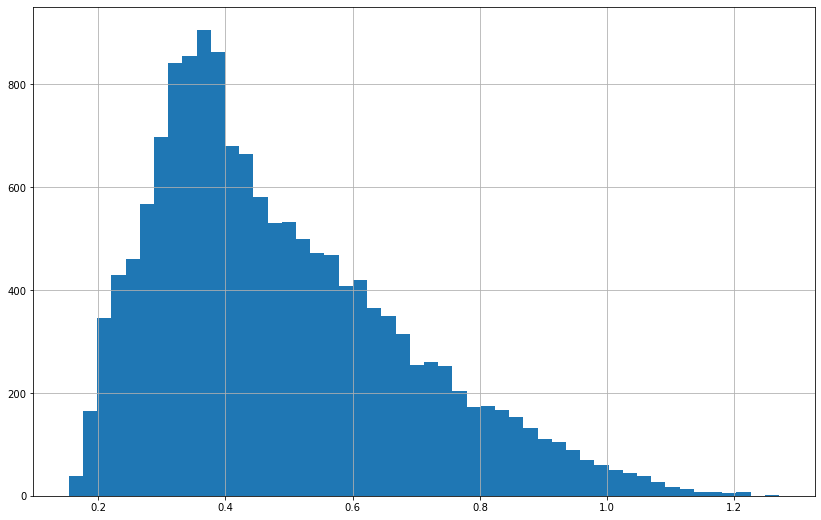

In [6]:
data_arc[data_arc['Реактивная мощность']>0]['Реактивная мощность'].hist(bins=50, figsize=(14,9));

In [7]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


- 14876 строк
- Пропуски отсутствуют
- Странное значение реактивной мощности в партии от 2019-07-28 № 2116 (`-715,48`) вероятно ошибка измерительного прибора
- Замеры произведены на 3241 партиях
- Среднее значения Активной и Реактивной мощности соответственно равно 0.60 и 0.44

## Объём подачи сыпучих материалов

In [8]:
check_data(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0



_________________ Информация _________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

_________________ Статистика _________________



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



__________________ Пропуски(%) __________________

key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64


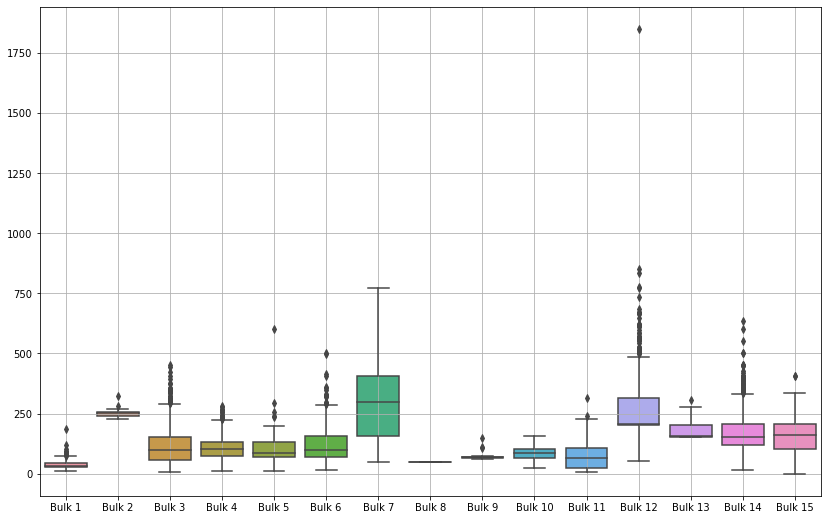

In [9]:
plt.figure(figsize=(14,9))
sns.boxplot(data=data_bulk.drop('key', axis =1))
plt.grid();

- Огромное количество пропущенных значений, вероятно это обусловлено тех.Процессом каждый Bulk  имеет свой состав

## Время подачи сыпучих материалов

In [10]:
check_data(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 17:26:33,2019-09-06 17:23:15



_________________ Информация _________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

_________________ Статистика _________________



,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



__________________ Пропуски(%) __________________

key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64


- Наполнение датасета data_bulk_time соотвествует data_bulk

## Данные о продувке сплава газом

In [11]:
check_data(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561


,key,Газ 1
3237,3240,11.863103
3238,3241,12.680959



_________________ Информация _________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

_________________ Статистика _________________



,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



__________________ Пропуски(%) __________________

key      0.0
Газ 1    0.0
dtype: float64


<AxesSubplot:>

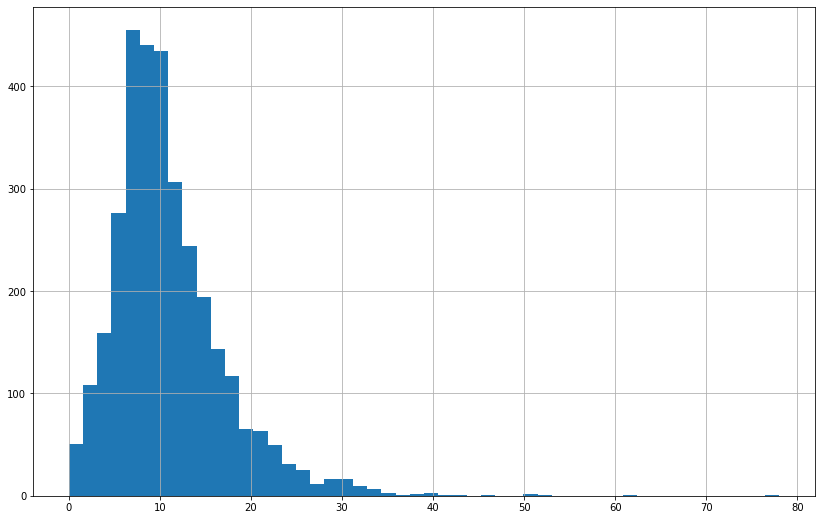

In [12]:
data_gas['Газ 1'].hist(bins=50, figsize=(14,9))

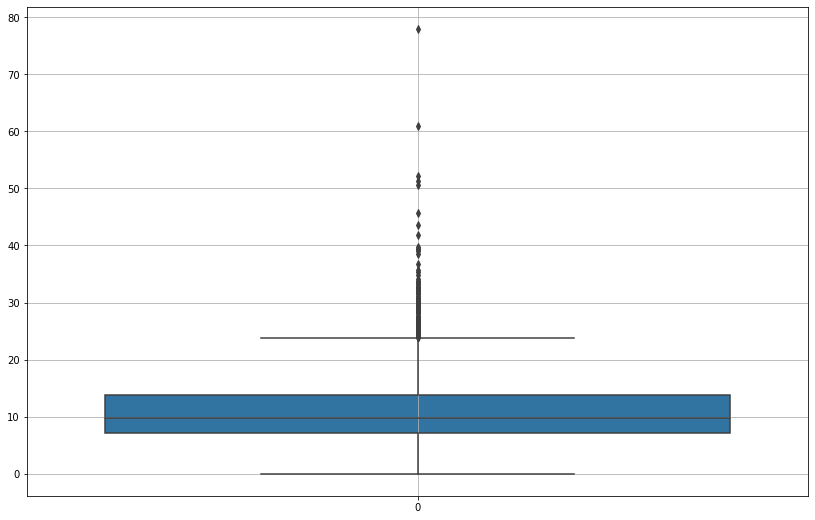

In [13]:
plt.figure(figsize=(14,9))
sns.boxplot(data=data_gas['Газ 1'])
plt.grid();

- Пропуски отсутствуют
- Среднее значения продувки газом 9.84

## Результаты измерения температуры

In [14]:
data_temp[data_temp['Температура'].isnull()]

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [15]:
check_data(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0


,key,Время замера,Температура
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN



_________________ Информация _________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None

_________________ Статистика _________________



,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000



__________________ Пропуски(%) __________________

key              0.000000
Время замера     0.000000
Температура     18.942074
dtype: float64


- 18091 строки
- Пропуски в 18,94 % по столбцу 'Температура'
- Среднее значения температуры 1590 градусов (Температура плавления стали, содержащий не менее 45% железа 1450-1520 градусов)

## Объём подачи проволочных материалов

In [16]:
check_data(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



_________________ Информация _________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

_________________ Статистика _________________



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



__________________ Пропуски(%) __________________

key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64


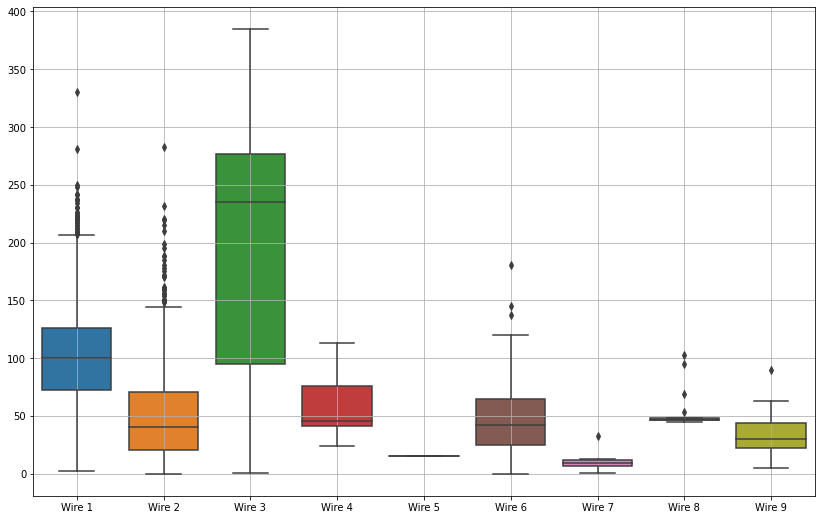

In [17]:
plt.figure(figsize=(14,9))
sns.boxplot(data=data_wire.drop('key', axis =1))
plt.grid();

- Количество пропущенных значений можно интерпретировать следующим образом - почти в каждой партии используется преимущественно 1 и 2 вид проволочных материалов

## Время подачи проволочных материалах

In [18]:
check_data(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



_________________ Информация _________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

_________________ Статистика _________________



,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



__________________ Пропуски(%) __________________

key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64


- Наполнение датасета data_wire_time соответствует data_wire

## Вывод по обзору данных

- Рассмотрено 7 датасетов.


- Датасеты хранят информацию о 3241 партиях.


- Среднее значения Активной и Реактивной мощности соответственно равно 0.60 и 0.44. 
В данных о электродах есть странное значение реактивной мощности в партии от 2019-07-28 № 2116 (`-715,48`) вероятно ошибка измерительного прибора, необходимо будет удалить т.к это искажает данные, для агрегирования по ключу партии.


- Пропуски в 18,94 % по столбцу 'Температура'.
- Среднее значения температуры 1590 градусов (Температура плавления стали, содержащий не менее 45% железа 1450-1520 градусов).


- Среднее значения продувки газом 9.84.


- Почти в каждой партии используется преимущественно 1 и 2 вид проволочных материалов.
- Большое количество пропущенных значений в данных о сыпучих материалов обусловлено тех.Процессом каждый Bulk имеет свой состав.


- Наполнение датасета data_bulk_time соответствует data_bulk.
- Наполнение датасета data_wire_time соответствует data_wire.

# Предобработка данных

Объединим датасеты в один и сгенерируем новые параметры для обучения моделей

## Мощность 

Избавимся от странного отрицательного показателя реактивной мощности 

In [19]:
data_arc = data_arc[data_arc['Реактивная мощность']>0]

Посчитаем количество нагревов и среднюю активную мощность этих нагревов по каждому ковшу

In [20]:
data_arc_new = data_arc.groupby(by='key').agg(Active_power = ('Активная мощность', 'mean'),
                                              Reactive_power = ('Реактивная мощность', 'mean'),
                                              Count_heating = ('key', 'count')).reset_index()

Добавим параметр полной мощности

Активная и реактивная мощность в совокупности – так называемая полная мощность. Она рассчитывается по следующей простой формуле:  
`√ (Активная мощность2 + Реактивная мощность2)`

Источник: https://radiofiles.ru/beginners/aktivnaya-i-reaktivnaya-moschnost-opredelenie-formuly-dlya-chaynikov

In [21]:
data_arc_new['Power'] = np.sqrt(data_arc_new['Active_power']**2 + data_arc_new['Reactive_power']**2)

In [22]:
data_arc_new.head(3)

,key,Active_power,Reactive_power,Count_heating,Power
0,1,0.607346,0.428564,5,0.743328
1,2,0.534852,0.363339,4,0.646593
2,3,0.812728,0.587491,5,1.002833


## Температура

Удалим данные с температурой ниже 1500

In [23]:
not_true_temperature = data_temp['key'].loc[data_temp['Температура'] < 1500]

In [24]:
not_true_temperature

4883      867
6784     1214
9050     1619
11495    2052
14283    2561
Name: key, dtype: int64

In [25]:
data_temp.drop(not_true_temperature.index, inplace = True)

In [26]:
data_temp[data_temp['Температура'] < 1500]

,key,Время замера,Температура


Рассчитаем дату первого и последнего замера температуры, время нагрева и температуру соответственно.

In [27]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

In [28]:
data_temp_new = data_temp.groupby(by='key').agg(['first','last', 'count']).reset_index()

In [29]:
data_temp_new.columns = ['key','first_time','last_time','count_time' ,'first_temp','last_temp','count_temp']

In [30]:
data_temp_new['time'] = data_temp_new['last_time'] - data_temp_new['first_time']

In [31]:
data_temp_new['time'] = data_temp_new['time'].dt.seconds

Удалим партии, где конченая и начальная температура равны

In [32]:
data_temp_new = data_temp_new[data_temp_new['count_temp'] != 1]

In [33]:
data_temp_new = data_temp_new[data_temp_new['first_temp'] != data_temp_new['last_temp']]

In [34]:
display(data_temp_new[data_temp_new['first_temp']==data_temp_new['last_temp']])

,key,first_time,last_time,count_time,first_temp,last_temp,count_temp,time


Удалим даты

In [35]:
data_temp_new.drop(['first_time','last_time'], axis =1, inplace=True);

In [36]:
data_temp_new.describe()

,key,count_time,first_temp,last_temp,count_temp,time
count,2433.000000,2433.000000,2432.000000,2432.000000,2433.000000,2433.000000
mean,1249.560625,5.628442,1588.934622,1595.352385,5.626387,2283.371969
std,720.931064,1.614097,25.116271,16.020644,1.618076,1380.459789
min,1.000000,2.000000,1519.000000,1541.000000,0.000000,270.000000
25%,626.000000,5.000000,1571.000000,1587.000000,5.000000,1547.000000
50%,1250.000000,5.000000,1588.000000,1593.000000,5.000000,2007.000000
75%,1871.000000,7.000000,1606.000000,1599.000000,7.000000,2738.000000
max,2561.000000,17.000000,1679.000000,1700.000000,17.000000,23674.000000


## Сыпучие материалы

Заменим отсутствующие значения на 0, для того чтобы оставить для модели все типы сыпучих материалов

In [37]:
data_bulk_new = data_bulk.fillna(0)

~~Найдем сумму всех добавок для каждой партии~~

In [38]:
#data_bulk_new['Bulk'] = data_bulk.iloc[:,1:].sum(axis= 1)

In [39]:
data_bulk_new.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0


## Газ

Переименуем колонку 

In [40]:
data_gas.columns = ['key','Gas']

In [41]:
data_gas.head(2)

,key,Gas
0,1,29.749986
1,2,12.555561


In [42]:
data_gas = data_gas[data_gas['Gas'] < 25]

## Проволочные материалы

Заменим отсутствующие значения на 0, для того чтобы оставить для модели все типы проволочных материалов

In [43]:
data_wire_new = data_wire.fillna(0)

In [45]:
data_wire_new.head(2)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Объединим данные в одну таблицу

In [46]:
data = (data_arc_new.merge(data_temp_new, how='inner', on = 'key'
                          ).merge(data_gas, how='inner', on = 'key'
                          ).merge(data_bulk_new, how='inner', on = 'key'
                          ).merge(data_wire_new, how='inner', on = 'key'))

In [47]:
data = data.dropna().reset_index(drop=True)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206 entries, 0 to 2205
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2206 non-null   int64  
 1   Active_power    2206 non-null   float64
 2   Reactive_power  2206 non-null   float64
 3   Count_heating   2206 non-null   int64  
 4   Power           2206 non-null   float64
 5   count_time      2206 non-null   int64  
 6   first_temp      2206 non-null   float64
 7   last_temp       2206 non-null   float64
 8   count_temp      2206 non-null   int64  
 9   time            2206 non-null   int64  
 10  Gas             2206 non-null   float64
 11  Bulk 1          2206 non-null   float64
 12  Bulk 2          2206 non-null   float64
 13  Bulk 3          2206 non-null   float64
 14  Bulk 4          2206 non-null   float64
 15  Bulk 5          2206 non-null   float64
 16  Bulk 6          2206 non-null   float64
 17  Bulk 7          2206 non-null   f

In [49]:
data.head(3)

,key,Active_power,Reactive_power,Count_heating,Power,count_time,first_temp,last_temp,count_temp,time,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,2,0.534852,0.363339,4,0.646593,5,1581.0,1602.0,5,1265,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.676622,0.514248,4,0.849864,5,1601.0,1625.0,5,1220,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.563238,0.421998,4,0.703789,5,1576.0,1602.0,5,1536,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


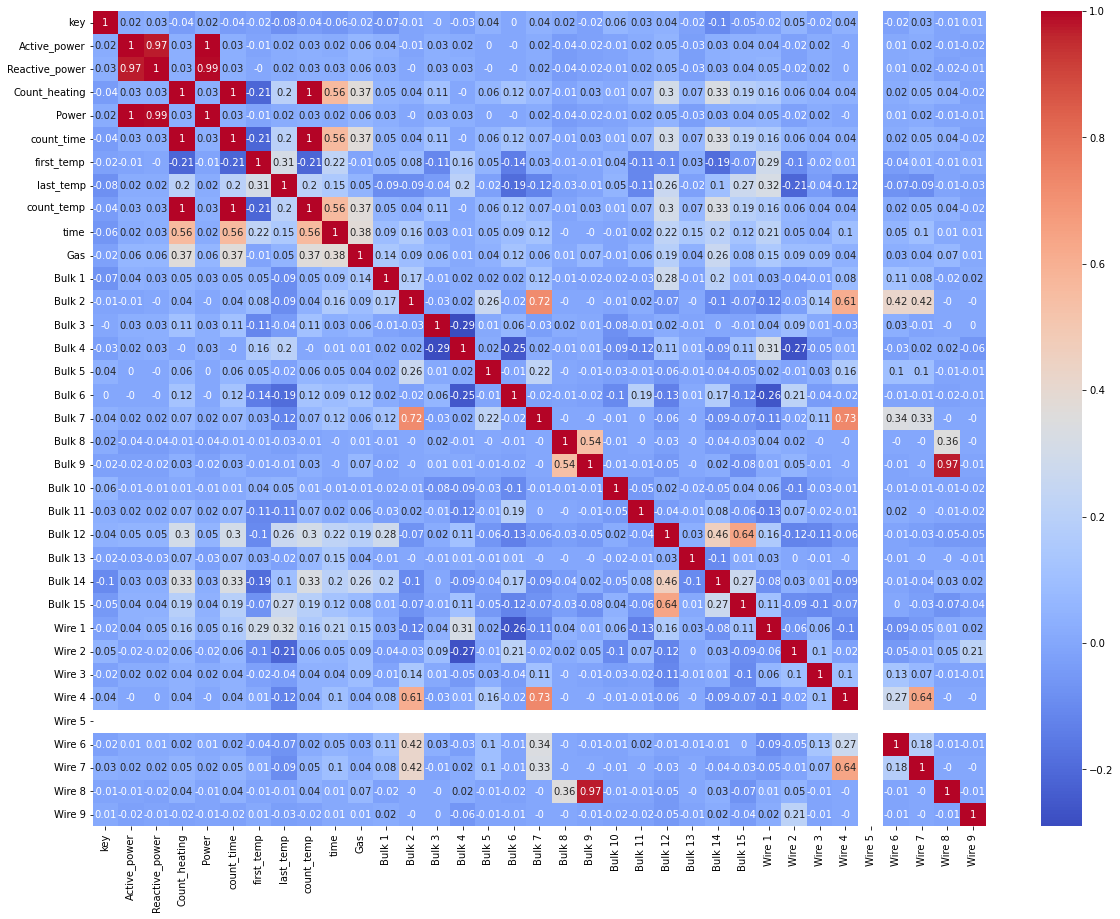

In [50]:
plt.figure(figsize = (20,15))
sns.heatmap(round(data.corr(),2), annot = True, cmap = 'coolwarm');

Сильная корреляция между Bulk 9 и Wire 8 (0.97), удалим Wire 8

In [51]:
data.drop(['Wire 8'], axis = 1, inplace=True)

Сильная корреляция между Wire 4 c Bulk 2 и Bulk 7, удалим Wire 4

In [52]:
data.drop(['Wire 4'], axis = 1, inplace=True)

После объединения не осталось данных для Wire 5, удалим этот столбец

In [53]:
data.drop(['Wire 5'], axis = 1, inplace=True)

**ОПЦИОНАЛЬНО**

In [54]:
data.drop(['Active_power','Reactive_power'], axis =1, inplace=True)

In [55]:
data.drop(['Wire 6', 'Bulk 7'], axis = 1, inplace=True)

In [56]:
data.drop(['count_temp', 'count_time'], axis = 1, inplace=True)

In [57]:
#data.drop(['Count_heating'], axis = 1, inplace=True)

In [58]:
#data.drop(['Bulk 7', 'Bulk 1', 'Bulk 4', 'Bulk 3', 'Bulk 11', 'Bulk 10', 'Bulk 2', 'Bulk 13', 'Bulk 8', 'Bulk 5', 'Wire 6', 'Wire 3', 'Wire 8', 'Wire 7', 'Wire 9'], axis = 1, inplace=True)

In [59]:
#data.drop(['time'], axis = 1, inplace=True)

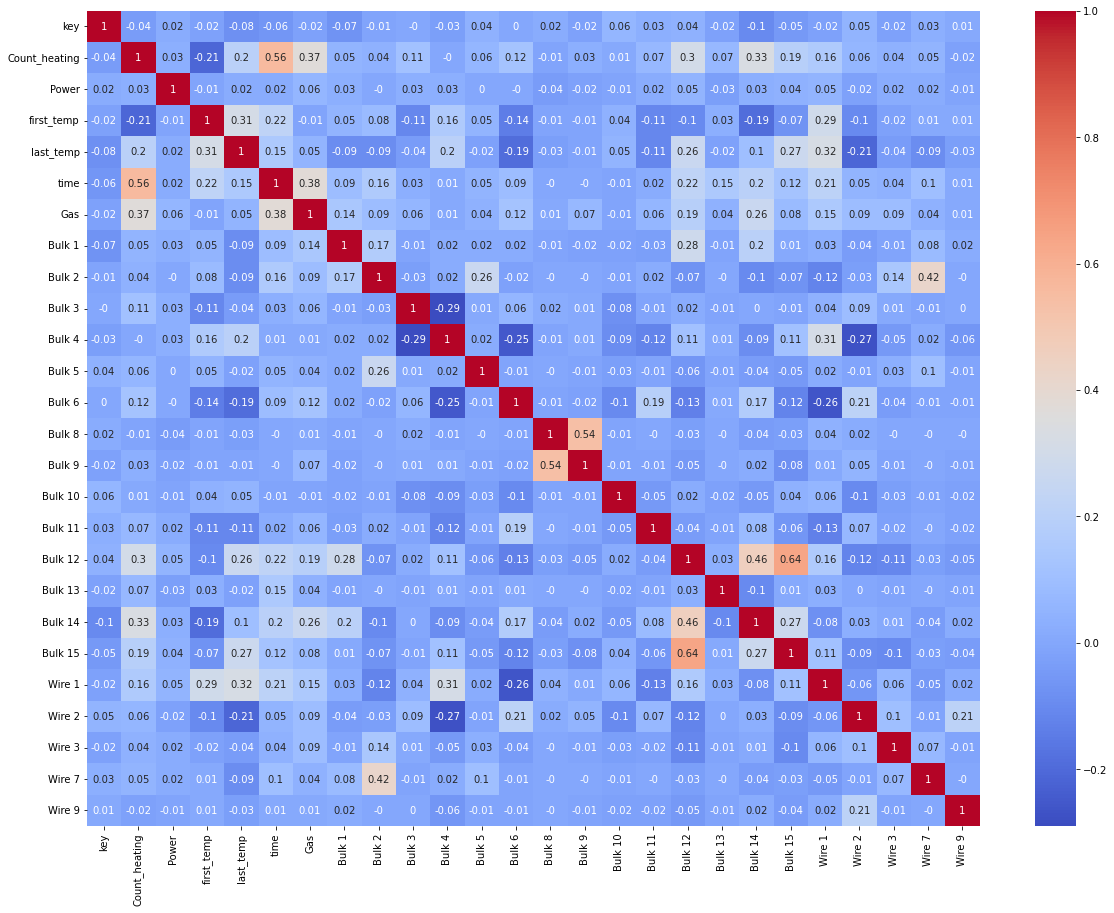

In [60]:
plt.figure(figsize = (20,15))
sns.heatmap(round(data.corr(),2), annot = True, cmap = 'coolwarm');

# Обучение моделей

## Разделение на выборки

In [61]:
train, test = train_test_split(data, test_size=0.25, random_state=RND)

Размер тестовой

In [62]:
train.shape

(1654, 26)

Размер тренировочной

In [63]:
test.shape

(552, 26)

Разделение на признаки и целевой признак, так же удалим столбец с номером партии он будет мешать моделям

In [64]:
test_features_plt = test.drop(['last_temp','key'], axis =1)

In [65]:
train_features = train.drop(['last_temp','key'], axis =1)
train_target = train['last_temp']

test_features = test.drop(['last_temp','key'], axis =1)
test_target = test['last_temp']

In [66]:
scaler = StandardScaler()
scaler.fit(train_features)
s_train_features = scaler.transform(train_features)
s_test_features = scaler.transform(test_features)

## Обучим модели и проверим mae на:
## Константной, Линейной регресии, Случайном лесе и CatBoost

## Константная модель

In [67]:
const_model = pd.Series(train_target.median(), index=train_target.index)

const_MaE = mean_absolute_error(train_target, const_model)

In [68]:
print('MaE для константной модели', "{:.3f}".format(const_MaE))

MaE для константной модели 7.981


## Линейная регрессия

In [69]:
%%time

regression = LinearRegression()

regression.fit(train_features, train_target)

regression_cv_score = pd.Series(cross_val_score(regression,
                                                train_features,
                                                train_target,
                                                scoring='neg_mean_absolute_error',
                                                cv=10,)).mean()*(-1)

CPU times: user 249 ms, sys: 20.1 ms, total: 269 ms
Wall time: 54.9 ms


In [70]:
print('MaE train LinearRegression:', "{:.3f}".format(regression_cv_score))

MaE train LinearRegression: 6.909


## Случайный лес

In [71]:
%%time

forest = RandomForestRegressor(random_state=RND)

forest_parametrs = { 'n_estimators': range(2, 50, 2),
                     'max_depth': range(1, 20, 2),
                   }


forest_grid = GridSearchCV(forest,
                           forest_parametrs,
                           scoring='neg_mean_absolute_error',
                           cv=10);
forest_grid.fit(train_features, train_target)

CPU times: user 3min 55s, sys: 951 ms, total: 3min 56s
Wall time: 3min 56s


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=240423),
             param_grid={'max_depth': range(1, 20, 2),
                         'n_estimators': range(2, 50, 2)},
             scoring='neg_mean_absolute_error')

In [72]:
forest_params = forest_grid.best_params_
forest_score = forest_grid.best_score_ * (-1) #forest_grid.score(s_train_features, train_target) * (-1) 
print(forest_params)
print('MaE train RandomForestRegressor:', "{:.3f}".format(forest_score))

{'max_depth': 7, 'n_estimators': 48}
MaE train RandomForestRegressor: 6.837


## CatBoost

In [73]:
%%time

cb = CatBoostRegressor(random_state=RND)

cb_parametrs = {'iterations': [100],
                'depth': range(1, 20, 2),
                'learning_rate' : [0.01, 0.05, 0.1]
               }

cb_grid = GridSearchCV(cb,
                       cb_parametrs,
                       scoring='neg_mean_absolute_error',
                       cv=10)

cb_grid.fit(train_features, train_target, verbose=0)

CPU times: user 1h 9min 1s, sys: 18min 12s, total: 1h 27min 14s
Wall time: 16min 8s


/Users/vladkondratov/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/vladkondratov/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladkondratov/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/Users/vladkondratov/o

GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostRegressor object at 0x136b5b280>,
             param_grid={'depth': range(1, 20, 2), 'iterations': [100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_absolute_error')

In [74]:
cb_params = cb_grid.best_params_
cb_score = cb_grid.best_score_ * (-1) #cb_grid.score(train_features, train_target) * (-1)
print(cb_params)
print('MaE train CatBoostRegressor:', "{:.3f}".format(cb_score))

{'depth': 7, 'iterations': 100, 'learning_rate': 0.1}
MaE train CatBoostRegressor: 6.668


In [75]:
columns = ['Модель','MaE']
const_model = ['Константная модель', "{:.3f}".format(const_MaE)]
linear_regression = ['Линейная регрессия', "{:.3f}".format(regression_cv_score)]
random_forest = ['Случайный лес', "{:.3f}".format(forest_score)]
cb_model = ['CatBoostClassifier', "{:.3f}".format(cb_score)]
table = pd.DataFrame([const_model, linear_regression, random_forest, cb_model], columns = columns)

display(table)

,Модель,MaE
0,Константная модель,7.981
1,Линейная регрессия,6.909
2,Случайный лес,6.837
3,CatBoostClassifier,6.668


Лучшие показатели MaE на тренировочной выборке показала модель CatBoostRegressor

# Оценка лучшей модели на тестовой выборке

In [76]:
model = CatBoostRegressor(**cb_params,random_state=RND)
model.fit(train_features, train_target, verbose=0)
predictions = model.predict(test_features)
MaE = mean_absolute_error(test_target, predictions)

In [77]:
print('MaE train CatBoostRegressor:',"{:.3f}".format(MaE))

MaE train CatBoostRegressor: 6.466


In [78]:
pd.Series(model.feature_importances_, 
                            index=test_features_plt.columns
                               ).sort_values(ascending=False)

first_temp       17.440156
Wire 1           10.302928
Bulk 15           9.240602
Bulk 14           8.469035
Bulk 12           8.203757
Count_heating     7.985897
time              7.780069
Bulk 6            6.960507
Wire 2            5.008645
Gas               4.809914
Bulk 1            4.238281
Power             3.754508
Bulk 3            2.616897
Bulk 4            2.041419
Bulk 11           0.492102
Bulk 10           0.332977
Bulk 13           0.116337
Wire 3            0.076804
Bulk 2            0.062962
Bulk 5            0.047769
Wire 9            0.018433
Bulk 8            0.000000
Wire 7            0.000000
Bulk 9            0.000000
dtype: float64

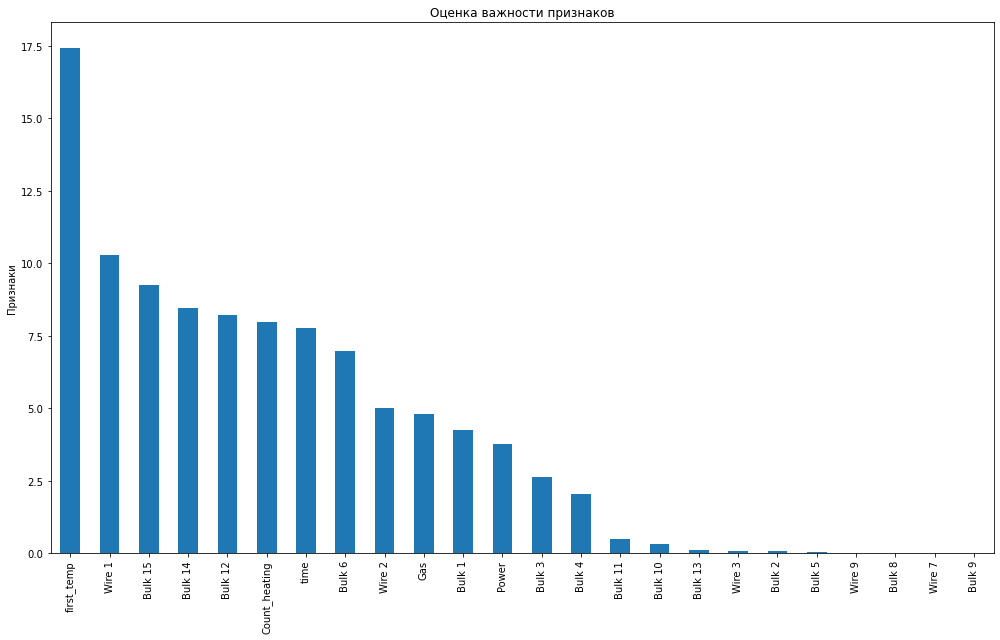

In [79]:
feature_importances = pd.Series(model.feature_importances_, 
                            index=test_features_plt.columns
                               ).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(14,9))
feature_importances.plot.bar(ax=ax)
ax.set_title('Оценка важности признаков')
ax.set_ylabel('Признаки')
fig.tight_layout()

# Вывод

- Данные подготовлены.
- Сформированы обучающая и тестовая выборка.
- Обучены модели LinearRegression, RandomForestRegressor, CatBoostRegressor.
- Подобраны наилучшие параметры для моделей.
- Выбрана модель с наилучшим MaE для проверки на тестовой выборке.
- MaE лучшей модели на тестовой выборке 6.466

# Отчет

**`1. Какие пункты плана были выполнены`**

Все пункты плана были выполнены:
- [x]  Загрузить и проанализировать данные
- [x]  Определить признаки для обучения моделей и целевой признак
- [x]  Построить и обучить модели, оценить их качество
- [x]  Оценка лучшей модели на тестовой выборке
- [x]  Вывод

**`2. Какие трудности возникли и как их преодолели`**

- **Проблема:** Отсутствие базовых знаний в сфере металлургии, в том числе технологического цикла и последовательности его процессов.
- **Решение:** https://habr.com/ru/companies/nlmk/articles/674530/ | https://metallplace.ru/about/stati-o-chernoy-metalurgii/desulfuratsiya/


- **Проблема:** Большое количество пропущенных значений в данных о легирующих добавках и проволочных материалах.
- **Решение:** Пропуски обусловлены технологическим процессом, были заменены заглушкой `0`.


- **Проблема:** Нерелевантные данные (наличие групп данных не соответствующих требованиям заказчика к технологическому процессу - температура ниже 1500 градусов), партии без конечного замера температуры которая является целевым признаком.
- **Решение:** Удаление нерелевантных данных.



**`3. Какие ключевые шаги в решении задачи были выделены`**

1. Загрузка данных и библиотек.
2. Анализ и предобработка данных.
3. Объединение данных в одну таблицу.
4. Обучение, оценка и выбор лучшей модели.
5. Тестирование лучшей модели.

**`4. Какие признаки использовались для обучения и какая была предобработка`**

- Пропуски в данных о легирующих добавках и проволочных материалах заменены на 0.
- Удаление аномального значения реактивной мощности.
- Удаление значений температуры ниже 1500 градусов.
- Удаление активной и реактивной мощности из  итоговой таблицы.
- Сгенерированы новые признаки:
    - Count_heating - количество подогревов сплава;
    - time - время нагрева;
    - Power - полная мощность.

**`5. Какая итоговая модель, гиперпараметры и качество`**

- Итоговая модель - CatBoostRegressor
- Лучшие гиперпараметры - depth 7, iterations 100, learning_rate 0.1
- MaE (средняя абсолютная ошибка, выраженная в градусах) -  6.466
- Наиболее значимые признаки для предсказания - first_temp, Wire 1, Bulk 15, Bulk 14, Bulk 12, Count_heating, time 